# 1. Business Understanding

## 1.1 Introduction

This project aims to classify sentiments in tweets mentioning Apple and Google products into three categories: positive, neutral, or negative. Sentiment analysis is a key application of natural language processing (NLP) that helps organizations understand public opinion at scale.


## 1.2 Problem Statement

Apple and Google depend heavily on the perception of their customers towards their products. As customers continue to give feedback on platforms such as Twitter(X), it is important to understand the sentiment of their feedback. This has lead to the development of models that can help classify these tweets.

## 1.3 Objectives

### 1.3.1 Main Objective

Build an accurate and efficient natural language processing model to classify tweets mentioning Apple and Google products into three sentiment categories: `positive`, `neutral` and `negative`.

### 1.3.2 Specific objectives

- To explore and analyze the tweet data and provide actionable insights

- To preprocess the data using Natural Language Processing techniques.

- To evaluate classifier performance using appropriate metrics



# 2. Data Understanding

In [3]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


## 2.1 Initial Data Loading and Inspection

In [4]:
judge = pd.read_csv('judge_data.csv', encoding='latin1')

judge.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [5]:
basic_info = {
    "Shape": judge.shape,
    "Columns": list(judge.columns),
    "Missing Values": judge.isnull().sum(),
    "Duplicate Rows": judge.duplicated().sum()
}


# Sentiment label overview

sentiment_counts = judge["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

# Brand/product mentions overview
brand_counts = judge["emotion_in_tweet_is_directed_at"].value_counts(dropna=False)

# Sample tweets from each sentiment

sample_tweets = (
    judge.groupby("is_there_an_emotion_directed_at_a_brand_or_product")["tweet_text"]
    .apply(lambda x: x.sample(1, random_state=42))
)

basic_info, sentiment_counts, brand_counts.head(10), sample_tweets

({'Shape': (9093, 3),
  'Columns': ['tweet_text',
   'emotion_in_tweet_is_directed_at',
   'is_there_an_emotion_directed_at_a_brand_or_product'],
  'Missing Values': tweet_text                                               1
  emotion_in_tweet_is_directed_at                       5802
  is_there_an_emotion_directed_at_a_brand_or_product       0
  dtype: int64,
  'Duplicate Rows': np.int64(22)},
 is_there_an_emotion_directed_at_a_brand_or_product
 No emotion toward brand or product    5389
 Positive emotion                      2978
 Negative emotion                       570
 I can't tell                           156
 Name: count, dtype: int64,
 emotion_in_tweet_is_directed_at
 NaN                                5802
 iPad                                946
 Apple                               661
 iPad or iPhone App                  470
 Google                              430
 iPhone                              297
 Other Google product or service     293
 Android App              

In [6]:
judge_clean = judge.drop_duplicates()
judge_clean = judge_clean.dropna(subset=["tweet_text"]).reset_index(drop=True)


sentiment_map = {
    "Positive emotion": "Positive",
    "Negative emotion": "Negative",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Neutral"
}


judge_clean["sentiment"] = judge_clean["is_there_an_emotion_directed_at_a_brand_or_product"].map(sentiment_map)
judge_clean["brand"] = judge_clean["emotion_in_tweet_is_directed_at"].fillna("Unknown")

def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()   


judge_clean["clean_text"] = judge_clean["tweet_text"].apply(clean_tweet)



data_overview = {
    "Shape after cleaning": judge_clean.shape,
    "Sentiment distribution": judge_clean["sentiment"].value_counts(),
    "Brand distribution": judge_clean["brand"].value_counts().head(10),
    "Nulls check": judge_clean.isnull().sum()
}


judge_clean.head(), data_overview



(                                          tweet_text  \
 0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
 1  @jessedee Know about @fludapp ? Awesome iPad/i...   
 2  @swonderlin Can not wait for #iPad 2 also. The...   
 3  @sxsw I hope this year's festival isn't as cra...   
 4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
 
   emotion_in_tweet_is_directed_at  \
 0                          iPhone   
 1              iPad or iPhone App   
 2                            iPad   
 3              iPad or iPhone App   
 4                          Google   
 
   is_there_an_emotion_directed_at_a_brand_or_product sentiment  \
 0                                   Negative emotion  Negative   
 1                                   Positive emotion  Positive   
 2                                   Positive emotion  Positive   
 3                                   Negative emotion  Negative   
 4                                   Positive emotion  Positive   
 
                 brand

In [7]:
judge_clean.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,sentiment,brand,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,iPhone,i have a 3g iphone after 3 hrs tweeting at ris...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,iPad or iPhone App,know about awesome ipadiphone app that youll l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive,iPad,can not wait for ipad 2 also they should sale ...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative,iPad or iPhone App,i hope this years festival isnt as crashy as t...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive,Google,great stuff on fri sxsw marissa mayer google t...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,Neutral,Unknown,new ipad apps for speechtherapy and communicat...
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Positive,Android,sxsw is just starting ctia is around the corne...
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Positive,iPad or iPhone App,beautifully smart and simple idea rt wrote abo...
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,Positive,Apple,counting down the days to sxsw plus strong can...
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,Positive,Android,excited to meet the at sxsw so i can show them...


C:\Users\Admin\AppData\Local\Temp\ipykernel_5788\3822288061.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


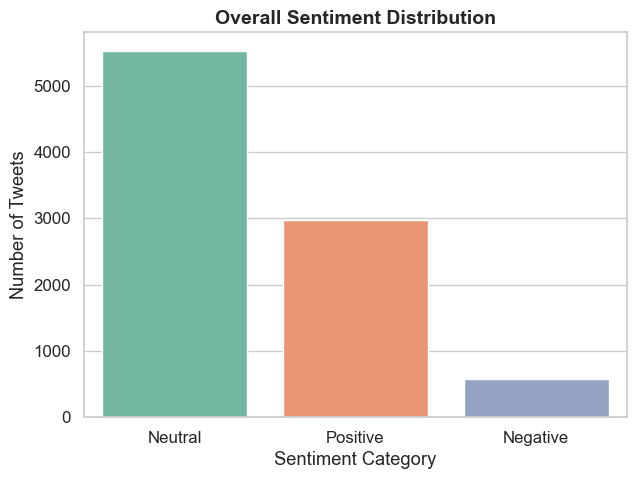

In [8]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Sentiment distribution

plt.figure(figsize=(7,5))
sns.countplot(
    data=judge_clean,
    x="sentiment",
    order=judge_clean["sentiment"].value_counts().index,
    palette="Set2"
)

plt.title("Overall Sentiment Distribution", fontsize=14, weight="bold")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.show()



C:\Users\Admin\AppData\Local\Temp\ipykernel_5788\415309230.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_brands, x="count", y="brand", palette="viridis")


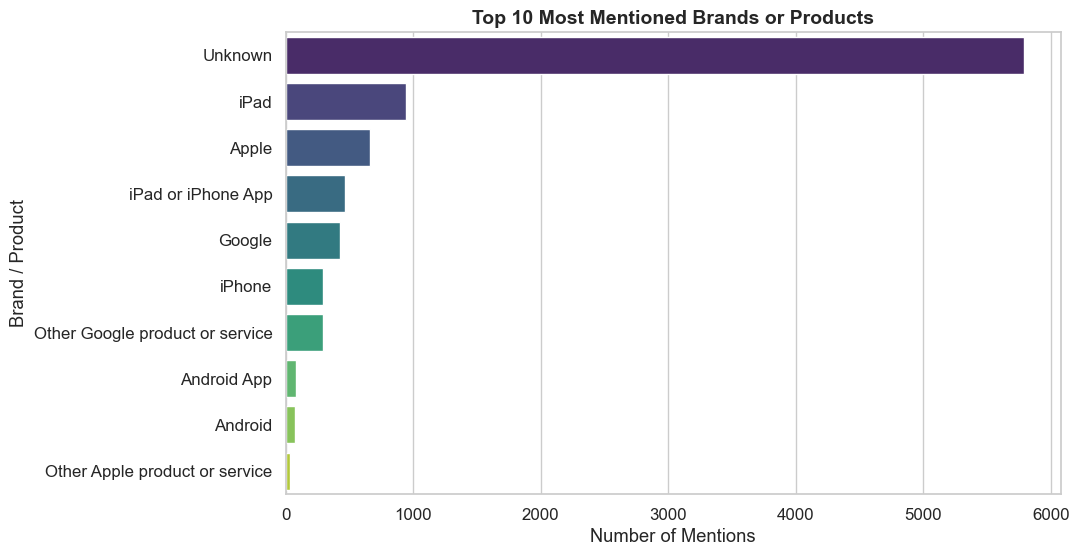

In [9]:
# top 10 brands or products mentioned

top_brands = (
    judge_clean["brand"]
    .value_counts()
    .reset_index()
)
top_brands.columns = ["brand", "count"]  
top_brands = top_brands.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_brands, x="count", y="brand", palette="viridis")
plt.title("Top 10 Most Mentioned Brands or Products", fontsize=14, weight="bold")
plt.xlabel("Number of Mentions")
plt.ylabel("Brand / Product")
plt.show()


In [10]:
def assign_brand_group(brand_name):
    brand_name = str(brand_name).lower()
    
    # ensure apple gets all iPad/iPhone app mentions
    if any(word in brand_name for word in ["apple", "ipad", "iphone", "ios", "itunes"]):
        return "Apple"
    elif any(word in brand_name for word in ["google", "android", "nexus", "pixel", "gmail", "maps"]):
        return "Google"
    else:
        return "Other/Unknown"

judge_clean["brand_group"] = judge_clean["brand"].apply(assign_brand_group)



judge_clean[["brand", "brand_group"]].head(10)



,brand,brand_group
0,iPhone,Apple
1,iPad or iPhone App,Apple
2,iPad,Apple
3,iPad or iPhone App,Apple
4,Google,Google
5,Unknown,Other/Unknown
6,Android,Google
7,iPad or iPhone App,Apple
8,Apple,Apple
9,Android,Google


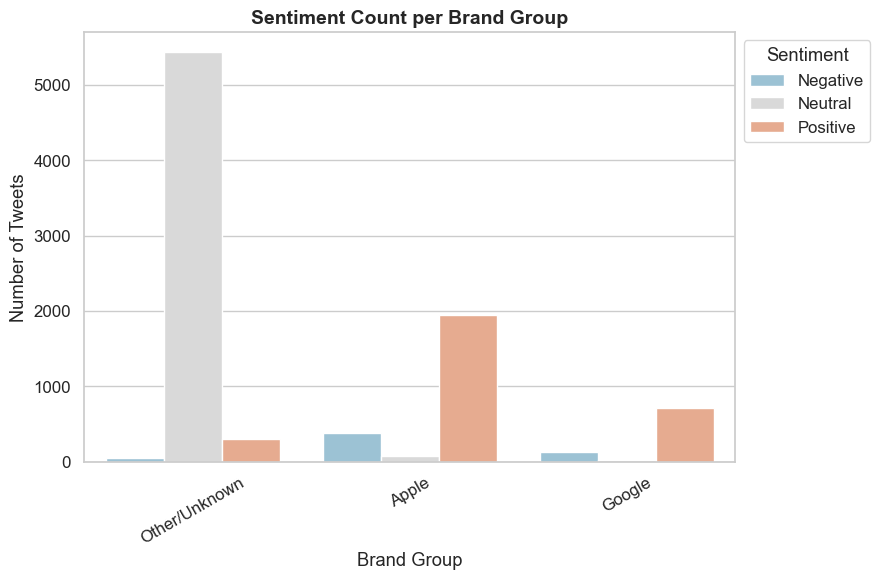

In [11]:
sentiment_counts = (
    judge_clean.groupby(["brand_group", "sentiment"])
    .size()
    .reset_index(name="count")
)


brand_order = (
    sentiment_counts.groupby("brand_group")["count"]
    .sum()
    .sort_values(ascending=False)
    .index
)


plt.figure(figsize=(9,6))
sns.barplot(
    data=sentiment_counts,
    x="brand_group",
    y="count",
    hue="sentiment",
    order=brand_order,
    palette={"Positive": "#f4a582", "Neutral": "#d9d9d9", "Negative": "#92c5de"}
)


plt.title("Sentiment Count per Brand Group", fontsize=14, weight="bold")
plt.xlabel("Brand Group")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=30)
plt.legend(title="Sentiment", loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [13]:


nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#", "", str(text))  
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


judge_clean["processed_text"] = judge_clean["clean_text"].apply(preprocess_text)


tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(judge_clean["processed_text"])
y = judge_clean["sentiment"]


X_tfidf.shape, len(tfidf.get_feature_names_out()), y.value_counts()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((9070, 3000),
 3000,
 sentiment
 Neutral     5531
 Positive    2970
 Negative     569
 Name: count, dtype: int64)

In [14]:
# split data into Train/Test sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", x_train.shape)
print("Test set:", x_test.shape)

Train set: (7256, 3000)
Test set: (1814, 3000)


In [15]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)


print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.58      0.06      0.11       114
     Neutral       0.70      0.88      0.78      1106
    Positive       0.63      0.44      0.52       594

    accuracy                           0.68      1814
   macro avg       0.64      0.46      0.47      1814
weighted avg       0.67      0.68      0.65      1814



In [16]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)



print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

    Negative       0.57      0.26      0.36       114
     Neutral       0.72      0.81      0.76      1106
    Positive       0.59      0.51      0.55       594

    accuracy                           0.68      1814
   macro avg       0.63      0.53      0.56      1814
weighted avg       0.67      0.68      0.67      1814



In [17]:
# Model Improvement

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


svm_balanced = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_balanced.fit(x_train, y_train)


y_pred_balanced = svm_balanced.predict(x_test)

print(" SVM Balanced")
print(classification_report(y_test, y_pred_balanced))
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))




 SVM Balanced
              precision    recall  f1-score   support

    Negative       0.28      0.54      0.37       114
     Neutral       0.77      0.67      0.72      1106
    Positive       0.56      0.59      0.57       594

    accuracy                           0.64      1814
   macro avg       0.54      0.60      0.55      1814
weighted avg       0.67      0.64      0.65      1814

Accuracy: 0.6361631753031973


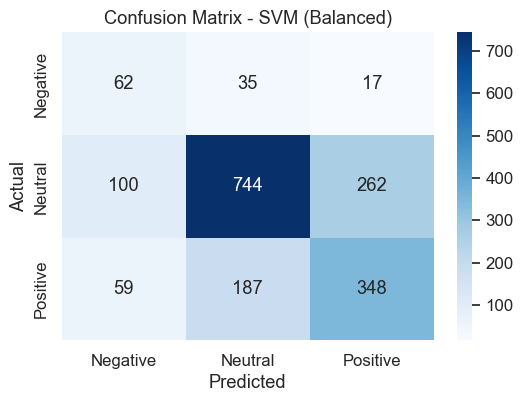

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred_balanced, labels=['Negative', 'Neutral', 'Positive'])


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (Balanced)')
plt.show()





In [19]:
from sklearn.svm import LinearSVC

tfidf_tuned = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

In [20]:
x_tfidf_tuned = tfidf_tuned.fit_transform(judge_clean["clean_text"])
y = judge_clean["sentiment"]

# Split again

x_train, x_test, y_train, y_test = train_test_split(x_tfidf_tuned, y, test_size=0.2, random_state=42)

svm_balanced_tuned = LinearSVC(class_weight='balanced', random_state=42)
svm_balanced_tuned.fit(x_train, y_train)


y_pred_tuned = svm_balanced_tuned.predict(x_test)

print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

    Negative       0.37      0.45      0.41       119
     Neutral       0.78      0.73      0.75      1139
    Positive       0.54      0.57      0.55       556

    accuracy                           0.67      1814
   macro avg       0.56      0.59      0.57      1814
weighted avg       0.68      0.67      0.67      1814



C:\Users\Admin\AppData\Local\Temp\ipykernel_5788\1058076328.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=judge_clean, x="sentiment", order=judge_clean["sentiment"].value_counts().index, palette="viridis")


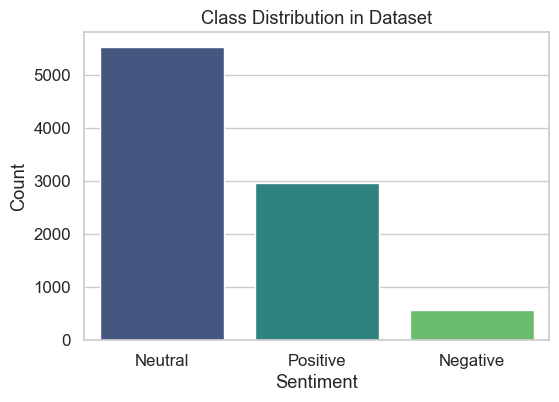

In [21]:
#Data Balance

plt.figure(figsize=(6,4))
sns.countplot(data=judge_clean, x="sentiment", order=judge_clean["sentiment"].value_counts().index, palette="viridis")
plt.title("Class Distribution in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [22]:
# fixing the bias model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# vectorize

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(judge_clean['clean_text'])
y = judge_clean['sentiment']


# oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X, y)

# train_test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# train the improved svm
svm_balanced_ngram = LinearSVC(class_weight='balanced', random_state=42)
svm_balanced_ngram.fit(X_train, y_train)

# evaluation
y_pred_ngram = svm_balanced_ngram.predict(X_test)
print(classification_report(y_test, y_pred_ngram))


              precision    recall  f1-score   support

    Negative       0.90      0.99      0.94      1106
     Neutral       0.78      0.68      0.72      1106
    Positive       0.77      0.79      0.78      1107

    accuracy                           0.82      3319
   macro avg       0.82      0.82      0.82      3319
weighted avg       0.82      0.82      0.82      3319



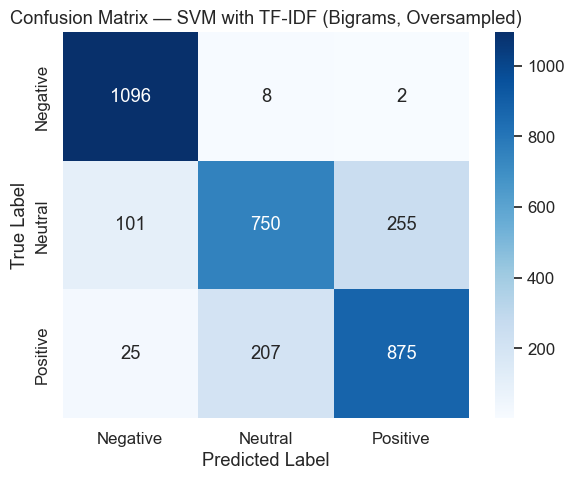

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred_ngram, labels=svm_balanced_ngram.classes_)


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=svm_balanced_ngram.classes_,
    yticklabels=svm_balanced_ngram.classes_
)
plt.title("Confusion Matrix — SVM with TF-IDF (Bigrams, Oversampled)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = [
    'sxsw', 'google', 'apple', 'ipad', 'iphone', 'android', 'app',
    'store', 'rt', 'link', 'austin', 'new', 'http', 'https', 'mention'
]


all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

top_n = 10

for sentiment in judge_clean['sentiment'].unique():
    subset = judge_clean[judge_clean['sentiment'] == sentiment]
    
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words=all_stopwords, 
        ngram_range=(1, 2),      
        min_df=2                  
    )
    
    tfidf_matrix = vectorizer.fit_transform(subset['clean_text'])
    
    mean_scores = tfidf_matrix.mean(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    top_indices = mean_scores.argsort()[::-1][:top_n]
    top_words = [words[i] for i in top_indices]
    
    print(f"\nTop words for '{sentiment}' sentiment:")
    print(top_words)







Top words for 'Negative' sentiment:
['just', 'like', 'people', 'apps', 'circles', 'design', 'social', 'battery', 'im', 'time']

Top words for 'Positive' sentiment:
['popup', 'just', 'ipad2', 'launch', 'amp', 'line', 'great', 'time', 'party', 'circles']

Top words for 'Neutral' sentiment:
['circles', 'social', 'launch', 'popup', 'amp', 'today', 'network', 'social network', 'called', 'line']


In [25]:
# people complain about usability and features
# people praise product launches
# people report events neutrality

In [26]:
import joblib

# Load the exact pair trained together
vectorizer = joblib.load("tfidf_vectorizer.pkl")
svm_model = joblib.load("sentiment_svm_balanced_model.pkl")

print("Vectorizer features:", len(vectorizer.get_feature_names_out()))
print("Model expects:", svm_model.n_features_in_)


Vectorizer features: 3000
Model expects: 3000


In [27]:
def predict_sentiment(text):
    processed = preprocess_text(text)
    vec = vectorizer.transform([processed])
    prediction = svm_model.predict(vec)
    return prediction[0]


test_tweets = [
    "Just updated my iPhone -  love new camera features!",
    "Google Assistant understand me perfectly this time. Impressed",
    "The new MacBook battery life is unbelievable. Great job, Apple!",
    "Android 15 feels super smooth. Finally some solid updates!",

    "Waiting for Apple's event next week, let's see what they announce",
    "Reading tech reviews on the new Pixel - looks interesting.",
    "Installed the latest iOS update this morning, no issues so far.",

    "My iPhone keeps overheating after the update. Totally annoying",
    "Google Drive crashed again while uploading my flies.",
    "Still can't connect to Wifi on my MacBook - what's wrong with this"
   
   

]

for tweet in test_tweets:
    print(f"{tweet} Sentiment: {predict_sentiment(tweet)}")


Just updated my iPhone -  love new camera features! Sentiment: Negative
Google Assistant understand me perfectly this time. Impressed Sentiment: Negative
The new MacBook battery life is unbelievable. Great job, Apple! Sentiment: Positive
Android 15 feels super smooth. Finally some solid updates! Sentiment: Negative
Waiting for Apple's event next week, let's see what they announce Sentiment: Neutral
Reading tech reviews on the new Pixel - looks interesting. Sentiment: Neutral
Installed the latest iOS update this morning, no issues so far. Sentiment: Negative
My iPhone keeps overheating after the update. Totally annoying Sentiment: Neutral
Google Drive crashed again while uploading my flies. Sentiment: Negative
Still can't connect to Wifi on my MacBook - what's wrong with this Sentiment: Negative


In [28]:
import joblib


vectorizer = joblib.load("tfidf_vectorizer.pkl")
svm_model = joblib.load("sentiment_svm_balanced_model.pkl")


print("Vectorizer features:", len(vectorizer.get_feature_names_out()))
print("Model expects:", svm_model.n_features_in_)


Vectorizer features: 3000
Model expects: 3000


In [29]:
import torch


In [39]:
from transformers import pipeline

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    framework="pt"
)

for tweet in test_tweets:
    result = sentiment_analyzer(tweet)[0]
    print(f"{tweet}  {result['label']} ({result['score']:.2f})")


test_tweets = [
    "Iphone 4 really works slow",
    "Just updated my iPhone -  love new camera features!",
    "Google Assistant understand me perfectly this time. Impressed",
    "The new MacBook battery life is unbelievable. Great job, Apple!",
    "Android 15 feels super smooth. Finally some solid updates!",

    "Waiting for Apple's event next week, let's see what they announce",
    "Reading tech reviews on the new Pixel - looks interesting.",
    "Installed the latest iOS update this morning, no issues so far.",

    "NVDIA will be making tiny home-devices",
    "repair my mac charger or buy a new one",

    "My iPhone keeps overheating after the update. Totally annoying",
    "Google Drive crashed again while uploading my flies.",
    "Still can't connect to Wifi on my MacBook - what's wrong with this" ,
    "only black phone covers should be that expensive",
    "new pixel or new iphone"
]

for tweet in test_tweets:
    result = sentiment_analyzer(tweet)[0]
    print(f"{tweet}  {result['label']} ({result['score']:.2f})")


Device set to use cpu


Iphone 4 really works slow  LABEL_0 (0.83)
Just updated my iPhone -  love new camera features!  LABEL_2 (0.99)
Google Assistant understand me perfectly this time. Impressed  LABEL_2 (0.97)
The new MacBook battery life is unbelievable. Great job, Apple!  LABEL_2 (0.99)
Android 15 feels super smooth. Finally some solid updates!  LABEL_2 (0.98)
Waiting for Apple's event next week, let's see what they announce  LABEL_2 (0.84)
Reading tech reviews on the new Pixel - looks interesting.  LABEL_2 (0.98)
Installed the latest iOS update this morning, no issues so far.  LABEL_2 (0.90)
NVDIA will be making tiny home-devices  LABEL_1 (0.76)
repair my mac charger or buy a new one  LABEL_1 (0.66)
My iPhone keeps overheating after the update. Totally annoying  LABEL_0 (0.96)
Google Drive crashed again while uploading my flies.  LABEL_0 (0.92)
Still can't connect to Wifi on my MacBook - what's wrong with this  LABEL_0 (0.97)
only black phone covers should be that expensive  LABEL_0 (0.51)
Iphone 4 real

In [40]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

for tweet in test_tweets:
    result = sentiment_analyzer(tweet)[0]
    label = label_map[result["label"]]
    print(f"{tweet}  {label} ({result['score']:.2f})")


Iphone 4 really works slow  Negative (0.83)
Just updated my iPhone -  love new camera features!  Positive (0.99)
Google Assistant understand me perfectly this time. Impressed  Positive (0.97)
The new MacBook battery life is unbelievable. Great job, Apple!  Positive (0.99)
Android 15 feels super smooth. Finally some solid updates!  Positive (0.98)
Waiting for Apple's event next week, let's see what they announce  Positive (0.84)
Reading tech reviews on the new Pixel - looks interesting.  Positive (0.98)
Installed the latest iOS update this morning, no issues so far.  Positive (0.90)
NVDIA will be making tiny home-devices  Neutral (0.76)
repair my mac charger or buy a new one  Neutral (0.66)
My iPhone keeps overheating after the update. Totally annoying  Negative (0.96)
Google Drive crashed again while uploading my flies.  Negative (0.92)
Still can't connect to Wifi on my MacBook - what's wrong with this  Negative (0.97)
only black phone covers should be that expensive  Negative (0.51)
n

In [36]:
# Torch Health

import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Torch version: 2.9.0+cpu
CUDA available: False
Device: cpu


In [41]:
# model verification and Retrival
import joblib

# save models

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(svm_model, "sentiment_svm_balanced_model.pkl")

print("Model and vectorizer have been saved")

Model and vectorizer have been saved


In [47]:


# Load saved models
vectorizer = joblib.load("tfidf_vectorizer.pkl")
svm_model = joblib.load("sentiment_svm_balanced_model.pkl")

# Quick verification
print("Vectorizer loaded with features:", len(vectorizer.get_feature_names_out()))
print("Model expects:", svm_model.n_features_in_)

# pipeline test
sample_text = ["Iphone4 is a bad and slow phone!!!"]
X_test = vectorizer.transform(sample_text)
prediction = svm_model.predict(X_test)
print("Predicted sentiment:", prediction[0])


Vectorizer loaded with features: 3000
Model expects: 3000
Predicted sentiment: Negative


END.
